In [1]:
# --------------------------------------------------------
# Pytorch multi-GPU Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Jiasen Lu, Jianwei Yang, based on code from Ross Girshick
# --------------------------------------------------------
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import sys
import numpy as np
import numpy.random as npr
import argparse
import pprint
import pdb
import time
import random

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data.sampler import Sampler
from torch.utils.data.sampler import BatchSampler

from roi_data_layer.roidb_VID import combined_roidb_VID
from roi_data_layer.roibatchLoader_VID import roibatchLoader_VID
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.utils.net_utils import weights_normal_init, save_net, load_net, \
      adjust_learning_rate, save_checkpoint, clip_gradient

#from model.faster_rcnn.vgg16 import vgg16
#from model.faster_rcnn.resnet import resnet
from model.faster_rcnn.faster_rcnn import _fasterRCNN
from model.siamese_net.siameseRCNN import _siameseRCNN
from easydict import EasyDict

torch.cuda.set_device(0)
def parse_args():
    """
    Parse input arguments
    """
    args = EasyDict()
    args['dataset'] = 'imagenetVID_1_vid'
    args['net'] = 'res101'
    args['start_epoch'] = 1
    args['max_epochs'] = 1
    args['disp_interval'] = 1
    args['checkpoint_interval'] = 10000
    args['save_dir'] = 'models'
    args['num_workers'] = 1
    args['cuda'] = True
    args['large_scale'] = False
    args['mGPUs'] = False
    args['batch_size'] = 2
    args['vid_size'] = 1
    args['class_agnostic'] = False
    args['optimizer'] = 'sgd'
    args['lr'] = 0.001
    args['lr_decay_step'] = 5
    args['lr_decay_gamma'] = 0.1
    args['session'] = 1
    args['resume'] = True
    args['checksession'] = 1
    args['checkepoch'] = 8
    args['checkpoint'] = 27452
    args['cfg_file'] = 'cfgs/res101_lighthead.yml'
    args['no_save'] = True
    args['ckpt'] = ''
    args['det_ckpt'] = ''

    return args

class batchSampler(BatchSampler):
    def __init__(self, sampler, batch_size):
        if not isinstance(sampler, Sampler):
            raise ValueError("sampler should be an instance of "
                             "torch.utils.data.Sampler, but got sampler={}"
                             .format(sampler))
        if batch_size <= 0:
            raise ValueError("batch_size should be a positive integeral value, "
                             "but got batch_size={}".format(batch_size))
        self.sampler = sampler
        self.batch_size = batch_size

    def __iter__(self):
        batch = []
        for idx in self.sampler:
            batch.append(idx)  # Difference: batch.append(int(idx))
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0:
            yield batch

    def __len__(self):
        return len(self.sampler) / self.batch_size

class sampler_imagenet_VID_sequential(Sampler):
    def __init__(self, train_size, lmdb, batch_size, vid_per_cat = 50, sample_gap_upper_bound = 10):
        '''
        This sampler samples batches from 1 video every time.
        :param train_size: the iteration per epoch.
        :param lmdb: the input lmdb.
        :param batch_size: number of video pairs for training.
        :param vid_per_cat: sampled video number for each category. Default 50.
        :param sample_gap_upper_bound: sample_gap_upper_bound is the maximum index gap to sample two images.
        '''
        assert train_size%batch_size==0, 'train_size should be divided by batch_size.'
        self._index_gap_upper_bound = sample_gap_upper_bound/lmdb._gap
        structured_indexes = lmdb._structured_indexes
        counter = 0
        samples = []

        # First, we sample the videos from each category.
        cat_idxs = list(range(30))
        sampled_vids_for_each_category = []
        for cat_idx in cat_idxs:
            vids = structured_indexes[cat_idx]
            if len(vids)>0:
                sampled_vids = vids
                sampled_vids_for_each_category.append(sampled_vids)
            else:
                sampled_vids_for_each_category.append([])
        # Next, we generate training sample indexes.
        cat_idxs = list(range(30))
        for cat_idx in cat_idxs:
            vids = sampled_vids_for_each_category[cat_idx]
            if len(vids)>0:
                # we only have 1 vid.
                vid = vids[0]
                for img_idx in range(len(vid)):
                    if img_idx==0:
                        samples.append((vid[img_idx],vid[img_idx]))
                    else:
                        samples.append((vid[img_idx-1],vid[img_idx]))
        self.samples = samples
    def __iter__(self):
        return iter(self.samples)

    def __len__(self):
        return len(self.samples)

class sampler_imagenet_VID(Sampler):
    def __init__(self, train_size, lmdb, batch_size, vid_per_cat = 50, sample_gap_upper_bound = 100):
        '''
        This sampler samples batches from 1 video every time.
        :param train_size: the iteration per epoch.
        :param lmdb: the input lmdb.
        :param batch_size: number of video pairs for training.
        :param vid_per_cat: sampled video number for each category. Default 50.
        :param sample_gap_upper_bound: sample_gap_upper_bound is the maximum index gap to sample two images.
        '''
        assert train_size%batch_size==0, 'train_size should be divided by batch_size.'
        self._index_gap_upper_bound = int(sample_gap_upper_bound/lmdb._gap)
        structured_indexes = lmdb._structured_indexes
        counter = 0
        samples = []
        while counter<train_size:
            # First, we sample the videos from each category.
            cat_idxs = list(range(30))
            sampled_vids_for_each_category = []
            for cat_idx in cat_idxs:
                vids = structured_indexes[cat_idx]
                if len(vids)>0:
                    sampled_vids = random.sample(vids, vid_per_cat)
                    sampled_vids_for_each_category.append(sampled_vids)
                else:
                    sampled_vids_for_each_category.append([])
            # Next, we generate training sample indexes.
            for vid_id in range(vid_per_cat):
                cat_idxs = list(range(30))
                random.shuffle(cat_idxs)
                for cat_idx in cat_idxs:
                    vids = sampled_vids_for_each_category[cat_idx]
                    if len(vids)>0:
                        vid = vids[vid_id]
                        for _ in range(batch_size):
                            item = random.sample(vid[:-self._index_gap_upper_bound], 1)
                            item = (item[0], item[0]+self._index_gap_upper_bound)
                            samples.append(item)
                            counter+=1
        self.samples = samples[:train_size]

    def __iter__(self):
        return iter(self.samples)

    def __len__(self):
        return len(self.samples)

def create_tensor_holder():
    # initilize the tensor holder here.
    im_data = torch.FloatTensor(1)
    im_info = torch.FloatTensor(1)
    num_boxes = torch.LongTensor(1)
    gt_boxes = torch.FloatTensor(1)

    # ship to cuda
    if args.cuda:
        im_data = im_data.cuda()
        im_info = im_info.cuda()
        num_boxes = num_boxes.cuda()
        gt_boxes = gt_boxes.cuda()

    # make variable
    im_data = Variable(im_data)
    im_info = Variable(im_info)
    num_boxes = Variable(num_boxes)
    gt_boxes = Variable(gt_boxes)
    return im_data,im_info,num_boxes,gt_boxes

def get_CNN_params(model, lr):
    params = []
    for key, value in dict(model.named_parameters()).items():
        if value.requires_grad:
            if 'bias' in key:
                params += [{'params': [value], 'lr': lr * (cfg.TRAIN.DOUBLE_BIAS + 1),
                            'weight_decay': cfg.TRAIN.BIAS_DECAY and cfg.TRAIN.WEIGHT_DECAY or 0}]
            else:
                params += [{'params': [value], 'lr': lr, 'weight_decay': cfg.TRAIN.WEIGHT_DECAY}]
    return params

import cPickle
import cPickle
import cPickle


In [2]:
args = parse_args()

print('Called with args:')
print(args)

if args.dataset == "imagenet":
    args.imdb_name = "imagenet_train"
    args.imdbval_name = "imagenet_val"
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == "imagenet_10_imgs":
    args.imdb_name = "imagenet_10_imgs_train"
    args.imdbval_name = "imagenet_10_imgs_val"
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == "imagenetVID_1_vid":
    args.imdb_name = 'imagenetVID_1_vid_train'
    args.imdbval_name = 'imagenetVID_1_vid_val'
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == "imagenetVID":
    args.imdb_name = 'imagenetVID_train'
    args.imdbval_name = 'imagenetVID_val'
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == 'imagenetDETVID':
    args.imdb_name = 'imagenetDETVID_train'
    args.imdbval_name = 'imagenetDETVID_val'
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']

if args.cfg_file is None:
    args.cfg_file = "cfgs/{}_ls.yml".format(args.net) if args.large_scale else "cfgs/{}.yml".format(args.net)

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfgs is not None:
    cfg_from_list(args.set_cfgs)

print('Using config:')
pprint.pprint(cfg)
np.random.seed(cfg.RNG_SEED)


Called with args:
{'checksession': 1, 'cfg_file': 'cfgs/res101_lighthead.yml', 'start_epoch': 1, 'dataset': 'imagenetVID_1_vid', 'ckpt': '', 'session': 1, 'max_epochs': 1, 'det_ckpt': '', 'mGPUs': False, 'disp_interval': 1, 'resume': True, 'checkpoint': 27452, 'lr': 0.001, 'net': 'res101', 'cuda': True, 'optimizer': 'sgd', 'num_workers': 1, 'batch_size': 2, 'checkepoch': 8, 'lr_decay_step': 5, 'vid_size': 1, 'no_save': True, 'large_scale': False, 'lr_decay_gamma': 0.1, 'save_dir': 'models', 'checkpoint_interval': 10000, 'class_agnostic': False}
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [4, 8, 16, 32],
 'CROP_RESIZE_WITH_MAX_POOL': False,
 'CUDA': False,
 'DATA_DIR': '/home/lvye/lvye/VODProj/faster-rcnn.pytorch/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'res101',
 'FEAT_STRIDE': [16],
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MAX_NUM_GT_BOXES': 30,
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,

lib/model/utils/config.py:444: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


### Training

In [3]:
#torch.backends.cudnn.benchmark = True
if torch.cuda.is_available() and not args.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# train set
# -- Note: Use validation set and disable the flipped to enable faster loading.
cfg.TRAIN.USE_FLIPPED = False
cfg.USE_GPU_NMS = args.cuda
# TODO change combined_roidb.
imdb, roidb, ratio_list, ratio_index = combined_roidb_VID(args.imdb_name)

print('{:d} roidb entries'.format(len(roidb)))

output_dir = args.save_dir + "/" + args.net + "/" + args.dataset
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# TODO change the dataloader and sampler.
train_size = 1500
my_sampler = sampler_imagenet_VID(
    train_size = train_size, 
    lmdb=imdb, 
    batch_size=args.batch_size, 
    vid_per_cat = 1, 
    sample_gap_upper_bound = 10)
my_batch_sampler = batchSampler(sampler = my_sampler, batch_size=args.batch_size)

dataset = roibatchLoader_VID(roidb, ratio_list, ratio_index, args.batch_size, imdb.num_classes, training=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=my_batch_sampler, num_workers=args.num_workers)

if args.cuda:
    cfg.CUDA = True

Loaded dataset `imagenetVID_1_vid_train` for training
Set proposal method: gt
Preparing training data...
/home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_1_vid_train_gt_roidb.pkl
wrote gt roidb to /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_1_vid_train_gt_roidb.pkl
Image sizes loaded from /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_1_vid_train_sizes.pkl
323
323
done
323 roidb entries


In [4]:
# initilize the network here.
if args.net == 'res101':
      RCNN = _siameseRCNN(imdb.classes, args)
else:
    print("network is not defined")
    pdb.set_trace()

lr = cfg.TRAIN.LEARNING_RATE
lr = args.lr
#tr_momentum = cfg.TRAIN.MOMENTUM
#tr_momentum = args.momentum

params = []
params = get_CNN_params(RCNN, lr)

if args.optimizer == "adam":
    lr = lr * 0.1
    optimizer = torch.optim.Adam(params)

elif args.optimizer == "sgd":
    optimizer = torch.optim.SGD(params, momentum=cfg.TRAIN.MOMENTUM)

assert args.cuda, 'Only cuda version is supported.'
RCNN.cuda()

assert not (args.ckpt is not '' and args.det_ckpt is not '')
if args.ckpt is not '':
    load_name_predix = cfg.RESNET.CORE_CHOICE.USE+'_siam'
    # TODO add OHEM later.
    if cfg.TRAIN.OHEM is True:
        load_name_predix = load_name_predix + '_OHEM'
    load_name = os.path.join(output_dir, load_name_predix + '_{}.pth'.format(args.ckpt))
    print("loading checkpoint %s" % (load_name))
    checkpoint = torch.load(load_name)
    args.session = checkpoint['session']
    #TODO
    #args.start_epoch = checkpoint['epoch']
    RCNN.load_state_dict(checkpoint['model'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    print("loaded checkpoint %s" % (load_name))
    
if args.det_ckpt is not '':
    load_name_predix = cfg.RESNET.CORE_CHOICE.USE
    load_name = os.path.join(output_dir, load_name_predix + '_{}.pth'.format(args.det_ckpt))
    print("loading checkpoint %s" % (load_name))
    checkpoint = torch.load(load_name)
    args.session = checkpoint['session']
    #TODO
    #args.start_epoch = checkpoint['epoch']
    RCNN.RCNN.load_state_dict(checkpoint['model'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    print("loaded checkpoint %s" % (load_name))

if args.mGPUs:
    RCNN = nn.DataParallel(RCNN)

iters_per_epoch = int(train_size / args.batch_size)

im_data_1, im_info_1, num_boxes_1, gt_boxes_1 = create_tensor_holder()
im_data_2, im_info_2, num_boxes_2, gt_boxes_2 = create_tensor_holder()

RCNN uses RFCN Light Head core.
Loading pretrained weights from data/pretrained_model/resnet101_caffe.pth


#### Start training.

In [ ]:
max_epoch = 10
for epoch in range(max_epoch):
    data_iter = iter(dataloader)
    loss_temp = 0
    start = time.time()
    for step in range(iters_per_epoch):
        data_1, data_2 = next(data_iter)

        im_data_1.data.resize_(data_1[0].size()).copy_(data_1[0])
        im_info_1.data.resize_(data_1[1].size()).copy_(data_1[1])
        gt_boxes_1.data.resize_(data_1[2].size()).copy_(data_1[2])
        num_boxes_1.data.resize_(data_1[3].size()).copy_(data_1[3])

        im_data_2.data.resize_(data_2[0].size()).copy_(data_2[0])
        im_info_2.data.resize_(data_2[1].size()).copy_(data_2[1])
        gt_boxes_2.data.resize_(data_2[2].size()).copy_(data_2[2])
        num_boxes_2.data.resize_(data_2[3].size()).copy_(data_2[3])
        
        #print(im_data.shape)
        RCNN.zero_grad()
        input = (im_data_1, im_info_1, num_boxes_1, gt_boxes_1, im_data_2, im_info_2, num_boxes_2, gt_boxes_2)
        rois, scores, rois_label, siamRPN_loss_cls, siamRPN_loss_box, rpn_loss_cls, rpn_loss_box, RCNN_loss_cls, RCNN_loss_bbox = RCNN(input)

        loss = rpn_loss_cls.mean() + rpn_loss_box.mean() \
             + RCNN_loss_cls.mean() + RCNN_loss_bbox.mean()\
             + siamRPN_loss_cls.mean() + siamRPN_loss_box.mean()
        loss_temp += loss.item()

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % args.disp_interval == 0:
            end = time.time()
        if step > 0:
            loss_temp /= (args.disp_interval + 1)

        if args.mGPUs:
            loss_siam_cls = siamRPN_loss_cls.mean().item()
            loss_siam_box = siamRPN_loss_box.mean().item()
            loss_rpn_cls = rpn_loss_cls.mean().item()
            loss_rpn_box = rpn_loss_box.mean().item()
            loss_rcnn_cls = RCNN_loss_cls.mean().item()
            loss_rcnn_box = RCNN_loss_bbox.mean().item()
        else:
            loss_siam_cls = siamRPN_loss_cls.item()
            loss_siam_box = siamRPN_loss_box.item()
            loss_rpn_cls = rpn_loss_cls.item()
            loss_rpn_box = rpn_loss_box.item()
            loss_rcnn_cls = RCNN_loss_cls.item()
            loss_rcnn_box = RCNN_loss_bbox.item()

        fg_cnt = torch.sum(rois_label.data.ne(0))
        bg_cnt = rois_label.data.numel() - fg_cnt

        print("[session %d][epoch %2d][iter %4d/%4d] loss: %.4f, lr: %.2e" \
                                % (args.session, epoch, step, iters_per_epoch, loss_temp, lr))
        print("\t\t\tfg/bg=(%d/%d), time cost: %f" % (fg_cnt, bg_cnt, end-start))
        print("\t\t\trpn_cls: %.4f, rpn_box: %.4f, rcnn_cls: %.4f, rcnn_box %.4f" \
                      % (loss_rpn_cls, loss_rpn_box, loss_rcnn_cls, loss_rcnn_box))
        print("\t\t\tsiam_rpn_cls: %.4f, siam_rpn_box: %.4f" \
              % (loss_siam_cls, loss_siam_box))
        loss_temp = 0
        start = time.time()
        

[session 1][epoch  0][iter    0/ 750] loss: 4.8653, lr: 1.00e-03
			fg/bg=(10/502), time cost: 1.715908
			rpn_cls: 0.6638, rpn_box: 0.0306, rcnn_cls: 3.4279, rcnn_box 0.0319
			siam_rpn_cls: 0.6936, siam_rpn_box: 0.0174
[session 1][epoch  0][iter    1/ 750] loss: 2.3693, lr: 1.00e-03
			fg/bg=(7/505), time cost: 0.962645
			rpn_cls: 0.6401, rpn_box: 0.0105, rcnn_cls: 3.3810, rcnn_box 0.0202
			siam_rpn_cls: 0.6825, siam_rpn_box: 0.0042
[session 1][epoch  0][iter    2/ 750] loss: 2.2923, lr: 1.00e-03
			fg/bg=(5/507), time cost: 0.931903
			rpn_cls: 0.6036, rpn_box: 0.0092, rcnn_cls: 3.2862, rcnn_box 0.0047
			siam_rpn_cls: 0.6774, siam_rpn_box: 0.0035
[session 1][epoch  0][iter    3/ 750] loss: 2.1910, lr: 1.00e-03
			fg/bg=(5/507), time cost: 0.967624
			rpn_cls: 0.5533, rpn_box: 0.0093, rcnn_cls: 3.1593, rcnn_box 0.0071
			siam_rpn_cls: 0.6503, siam_rpn_box: 0.0026
[session 1][epoch  0][iter    4/ 750] loss: 2.1817, lr: 1.00e-03
			fg/bg=(30/482), time cost: 0.980562
			rpn_cls: 0.5

[session 1][epoch  0][iter   38/ 750] loss: 0.5525, lr: 1.00e-03
			fg/bg=(63/449), time cost: 1.107075
			rpn_cls: 0.0505, rpn_box: 0.0089, rcnn_cls: 0.4320, rcnn_box 0.2885
			siam_rpn_cls: 0.3213, siam_rpn_box: 0.0039
[session 1][epoch  0][iter   39/ 750] loss: 0.5972, lr: 1.00e-03
			fg/bg=(74/438), time cost: 1.002246
			rpn_cls: 0.0746, rpn_box: 0.0150, rcnn_cls: 0.5112, rcnn_box 0.3671
			siam_rpn_cls: 0.2139, siam_rpn_box: 0.0125
[session 1][epoch  0][iter   40/ 750] loss: 0.5853, lr: 1.00e-03
			fg/bg=(72/440), time cost: 1.156658
			rpn_cls: 0.0487, rpn_box: 0.0069, rcnn_cls: 0.4706, rcnn_box 0.3409
			siam_rpn_cls: 0.2992, siam_rpn_box: 0.0041
[session 1][epoch  0][iter   41/ 750] loss: 0.4904, lr: 1.00e-03
			fg/bg=(52/460), time cost: 1.211495
			rpn_cls: 0.0277, rpn_box: 0.0025, rcnn_cls: 0.3899, rcnn_box 0.2680
			siam_rpn_cls: 0.2914, siam_rpn_box: 0.0013
[session 1][epoch  0][iter   42/ 750] loss: 0.5049, lr: 1.00e-03
			fg/bg=(65/447), time cost: 1.074447
			rpn_cls: 

[session 1][epoch  0][iter   76/ 750] loss: 0.2526, lr: 1.00e-03
			fg/bg=(64/448), time cost: 1.031467
			rpn_cls: 0.0212, rpn_box: 0.0074, rcnn_cls: 0.0997, rcnn_box 0.2677
			siam_rpn_cls: 0.0990, siam_rpn_box: 0.0102
[session 1][epoch  0][iter   77/ 750] loss: 0.2106, lr: 1.00e-03
			fg/bg=(65/447), time cost: 0.999328
			rpn_cls: 0.0122, rpn_box: 0.0054, rcnn_cls: 0.0914, rcnn_box 0.2939
			siam_rpn_cls: 0.0155, siam_rpn_box: 0.0029
[session 1][epoch  0][iter   78/ 750] loss: 0.3928, lr: 1.00e-03
			fg/bg=(67/445), time cost: 1.089495
			rpn_cls: 0.0440, rpn_box: 0.0112, rcnn_cls: 0.2526, rcnn_box 0.3366
			siam_rpn_cls: 0.1374, siam_rpn_box: 0.0038
[session 1][epoch  0][iter   79/ 750] loss: 0.1932, lr: 1.00e-03
			fg/bg=(55/457), time cost: 1.071125
			rpn_cls: 0.0141, rpn_box: 0.0074, rcnn_cls: 0.0685, rcnn_box 0.2457
			siam_rpn_cls: 0.0447, siam_rpn_box: 0.0061
[session 1][epoch  0][iter   80/ 750] loss: 0.3708, lr: 1.00e-03
			fg/bg=(80/432), time cost: 1.403714
			rpn_cls: 

[session 1][epoch  0][iter  114/ 750] loss: 0.2167, lr: 1.00e-03
			fg/bg=(76/436), time cost: 1.202692
			rpn_cls: 0.0200, rpn_box: 0.0057, rcnn_cls: 0.0774, rcnn_box 0.2970
			siam_rpn_cls: 0.0299, siam_rpn_box: 0.0035
[session 1][epoch  0][iter  115/ 750] loss: 0.2856, lr: 1.00e-03
			fg/bg=(113/399), time cost: 1.121330
			rpn_cls: 0.0123, rpn_box: 0.0092, rcnn_cls: 0.0924, rcnn_box 0.4371
			siam_rpn_cls: 0.0106, siam_rpn_box: 0.0095
[session 1][epoch  0][iter  116/ 750] loss: 0.3227, lr: 1.00e-03
			fg/bg=(86/426), time cost: 1.080295
			rpn_cls: 0.0277, rpn_box: 0.0064, rcnn_cls: 0.2134, rcnn_box 0.3708
			siam_rpn_cls: 0.0241, siam_rpn_box: 0.0030
[session 1][epoch  0][iter  117/ 750] loss: 0.1522, lr: 1.00e-03
			fg/bg=(51/461), time cost: 0.993907
			rpn_cls: 0.0116, rpn_box: 0.0024, rcnn_cls: 0.0589, rcnn_box 0.2123
			siam_rpn_cls: 0.0185, siam_rpn_box: 0.0007
[session 1][epoch  0][iter  118/ 750] loss: 0.3810, lr: 1.00e-03
			fg/bg=(102/410), time cost: 1.090191
			rpn_cls

[session 1][epoch  0][iter  152/ 750] loss: 0.0910, lr: 1.00e-03
			fg/bg=(47/465), time cost: 0.983853
			rpn_cls: 0.0097, rpn_box: 0.0028, rcnn_cls: 0.0516, rcnn_box 0.0964
			siam_rpn_cls: 0.0200, siam_rpn_box: 0.0016
[session 1][epoch  0][iter  153/ 750] loss: 0.1736, lr: 1.00e-03
			fg/bg=(68/444), time cost: 0.992328
			rpn_cls: 0.0225, rpn_box: 0.0053, rcnn_cls: 0.0720, rcnn_box 0.2190
			siam_rpn_cls: 0.0242, siam_rpn_box: 0.0043
[session 1][epoch  0][iter  154/ 750] loss: 0.3700, lr: 1.00e-03
			fg/bg=(98/414), time cost: 1.209798
			rpn_cls: 0.0526, rpn_box: 0.0205, rcnn_cls: 0.2233, rcnn_box 0.3932
			siam_rpn_cls: 0.0458, siam_rpn_box: 0.0047
[session 1][epoch  0][iter  155/ 750] loss: 0.0952, lr: 1.00e-03
			fg/bg=(64/448), time cost: 1.121943
			rpn_cls: 0.0103, rpn_box: 0.0021, rcnn_cls: 0.0360, rcnn_box 0.1203
			siam_rpn_cls: 0.0175, siam_rpn_box: 0.0042
[session 1][epoch  0][iter  156/ 750] loss: 0.1604, lr: 1.00e-03
			fg/bg=(73/439), time cost: 1.210709
			rpn_cls: 

[session 1][epoch  0][iter  190/ 750] loss: 0.2065, lr: 1.00e-03
			fg/bg=(77/435), time cost: 1.161597
			rpn_cls: 0.0283, rpn_box: 0.0060, rcnn_cls: 0.1144, rcnn_box 0.2311
			siam_rpn_cls: 0.0307, siam_rpn_box: 0.0026
[session 1][epoch  0][iter  191/ 750] loss: 0.1642, lr: 1.00e-03
			fg/bg=(114/398), time cost: 1.193807
			rpn_cls: 0.0128, rpn_box: 0.0085, rcnn_cls: 0.0634, rcnn_box 0.2029
			siam_rpn_cls: 0.0180, siam_rpn_box: 0.0227
[session 1][epoch  0][iter  192/ 750] loss: 0.1685, lr: 1.00e-03
			fg/bg=(85/427), time cost: 1.189245
			rpn_cls: 0.0151, rpn_box: 0.0030, rcnn_cls: 0.0713, rcnn_box 0.2104
			siam_rpn_cls: 0.0291, siam_rpn_box: 0.0081
[session 1][epoch  0][iter  193/ 750] loss: 0.1223, lr: 1.00e-03
			fg/bg=(75/437), time cost: 1.159012
			rpn_cls: 0.0166, rpn_box: 0.0056, rcnn_cls: 0.0494, rcnn_box 0.1292
			siam_rpn_cls: 0.0306, siam_rpn_box: 0.0131
[session 1][epoch  0][iter  194/ 750] loss: 0.1073, lr: 1.00e-03
			fg/bg=(86/426), time cost: 1.031917
			rpn_cls:

[session 1][epoch  0][iter  228/ 750] loss: 0.1513, lr: 1.00e-03
			fg/bg=(77/435), time cost: 1.002405
			rpn_cls: 0.0087, rpn_box: 0.0015, rcnn_cls: 0.0842, rcnn_box 0.1975
			siam_rpn_cls: 0.0093, siam_rpn_box: 0.0014
[session 1][epoch  0][iter  229/ 750] loss: 0.1556, lr: 1.00e-03
			fg/bg=(105/407), time cost: 1.149437
			rpn_cls: 0.0152, rpn_box: 0.0092, rcnn_cls: 0.0695, rcnn_box 0.1804
			siam_rpn_cls: 0.0299, siam_rpn_box: 0.0070
[session 1][epoch  0][iter  230/ 750] loss: 0.0568, lr: 1.00e-03
			fg/bg=(48/464), time cost: 0.957285
			rpn_cls: 0.0057, rpn_box: 0.0022, rcnn_cls: 0.0412, rcnn_box 0.0566
			siam_rpn_cls: 0.0061, siam_rpn_box: 0.0018
[session 1][epoch  0][iter  231/ 750] loss: 0.0986, lr: 1.00e-03
			fg/bg=(96/416), time cost: 1.051834
			rpn_cls: 0.0174, rpn_box: 0.0064, rcnn_cls: 0.0509, rcnn_box 0.0999
			siam_rpn_cls: 0.0035, siam_rpn_box: 0.0191
[session 1][epoch  0][iter  232/ 750] loss: 0.0826, lr: 1.00e-03
			fg/bg=(73/439), time cost: 1.043781
			rpn_cls:

[session 1][epoch  0][iter  266/ 750] loss: 0.0551, lr: 1.00e-03
			fg/bg=(61/451), time cost: 1.095753
			rpn_cls: 0.0063, rpn_box: 0.0025, rcnn_cls: 0.0285, rcnn_box 0.0626
			siam_rpn_cls: 0.0086, siam_rpn_box: 0.0016
[session 1][epoch  0][iter  267/ 750] loss: 0.0868, lr: 1.00e-03
			fg/bg=(91/421), time cost: 1.230186
			rpn_cls: 0.0119, rpn_box: 0.0055, rcnn_cls: 0.0487, rcnn_box 0.0916
			siam_rpn_cls: 0.0057, siam_rpn_box: 0.0102
[session 1][epoch  0][iter  268/ 750] loss: 0.0863, lr: 1.00e-03
			fg/bg=(46/466), time cost: 1.191166
			rpn_cls: 0.0088, rpn_box: 0.0033, rcnn_cls: 0.0234, rcnn_box 0.1165
			siam_rpn_cls: 0.0162, siam_rpn_box: 0.0043
[session 1][epoch  0][iter  269/ 750] loss: 0.0441, lr: 1.00e-03
			fg/bg=(45/467), time cost: 1.116845
			rpn_cls: 0.0058, rpn_box: 0.0027, rcnn_cls: 0.0160, rcnn_box 0.0429
			siam_rpn_cls: 0.0139, siam_rpn_box: 0.0070
[session 1][epoch  0][iter  270/ 750] loss: 0.0918, lr: 1.00e-03
			fg/bg=(96/416), time cost: 1.210976
			rpn_cls: 

[session 1][epoch  0][iter  304/ 750] loss: 0.0936, lr: 1.00e-03
			fg/bg=(106/406), time cost: 1.127616
			rpn_cls: 0.0149, rpn_box: 0.0075, rcnn_cls: 0.0449, rcnn_box 0.0914
			siam_rpn_cls: 0.0214, siam_rpn_box: 0.0072
[session 1][epoch  0][iter  305/ 750] loss: 0.0813, lr: 1.00e-03
			fg/bg=(103/409), time cost: 1.197206
			rpn_cls: 0.0139, rpn_box: 0.0076, rcnn_cls: 0.0428, rcnn_box 0.0764
			siam_rpn_cls: 0.0095, siam_rpn_box: 0.0125
[session 1][epoch  0][iter  306/ 750] loss: 0.0333, lr: 1.00e-03
			fg/bg=(36/476), time cost: 1.096627
			rpn_cls: 0.0068, rpn_box: 0.0011, rcnn_cls: 0.0153, rcnn_box 0.0356
			siam_rpn_cls: 0.0068, siam_rpn_box: 0.0010
[session 1][epoch  0][iter  307/ 750] loss: 0.0437, lr: 1.00e-03
			fg/bg=(44/468), time cost: 1.037614
			rpn_cls: 0.0065, rpn_box: 0.0055, rcnn_cls: 0.0120, rcnn_box 0.0487
			siam_rpn_cls: 0.0101, siam_rpn_box: 0.0045
[session 1][epoch  0][iter  308/ 750] loss: 0.2385, lr: 1.00e-03
			fg/bg=(107/405), time cost: 1.532824
			rpn_cl

[session 1][epoch  0][iter  342/ 750] loss: 0.0482, lr: 1.00e-03
			fg/bg=(73/439), time cost: 1.177199
			rpn_cls: 0.0045, rpn_box: 0.0035, rcnn_cls: 0.0240, rcnn_box 0.0372
			siam_rpn_cls: 0.0200, siam_rpn_box: 0.0072
[session 1][epoch  0][iter  343/ 750] loss: 0.0370, lr: 1.00e-03
			fg/bg=(40/472), time cost: 0.988353
			rpn_cls: 0.0047, rpn_box: 0.0016, rcnn_cls: 0.0317, rcnn_box 0.0324
			siam_rpn_cls: 0.0025, siam_rpn_box: 0.0011
[session 1][epoch  0][iter  344/ 750] loss: 0.0350, lr: 1.00e-03
			fg/bg=(75/437), time cost: 1.130523
			rpn_cls: 0.0068, rpn_box: 0.0024, rcnn_cls: 0.0194, rcnn_box 0.0326
			siam_rpn_cls: 0.0036, siam_rpn_box: 0.0052
[session 1][epoch  0][iter  345/ 750] loss: 0.0828, lr: 1.00e-03
			fg/bg=(89/423), time cost: 1.257828
			rpn_cls: 0.0162, rpn_box: 0.0086, rcnn_cls: 0.0414, rcnn_box 0.0506
			siam_rpn_cls: 0.0321, siam_rpn_box: 0.0166
[session 1][epoch  0][iter  346/ 750] loss: 0.0602, lr: 1.00e-03
			fg/bg=(65/447), time cost: 1.287514
			rpn_cls: 

In [ ]:
# save model.
name_prefix = ''
if cfg.RESNET.CORE_CHOICE.USE == cfg.RESNET.CORE_CHOICE.FASTER_RCNN:
    name_prefix = 'faster_rcnn'
elif cfg.RESNET.CORE_CHOICE.USE == cfg.RESNET.CORE_CHOICE.RFCN_LIGHTHEAD:
    name_prefix = 'rfcn_light_head'
elif cfg.RESNET.CORE_CHOICE.USE == cfg.RESNET.CORE_CHOICE.RFCN:
    name_prefix = 'rfcn'
else:
    pass
name_prefix+'_siam'
save_name = os.path.join(output_dir, name_prefix + '_{}.pth'.format('temp'))
print('save_name:',save_name)

In [ ]:
save_checkpoint({
  'session': 1,
  'epoch': 1+1,
  'model': RCNN.module.state_dict() if args.mGPUs else RCNN.state_dict(),
  'optimizer': optimizer.state_dict(),
  'pooling_mode': cfg.POOLING_MODE,
  'class_agnostic': args.class_agnostic,
}, save_name)
print('save model: {}'.format(save_name))

In [9]:
torch.cuda.empty_cache()

### Testing

In [5]:
from model.siamese_net.weight_cropping_layer import weight_crop_layer
from model.rpn.bbox_transform import clip_boxes
from model.nms.nms_wrapper import nms
from model.rpn.bbox_transform import bbox_transform_inv
def bbox_delta_to_pred_boxes(im_info, boxes, bbox_pred):
    box_deltas = bbox_pred.data
    if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
        # Optionally normalize targets by a precomputed mean and stdev
        if args.class_agnostic:
            box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                         + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            box_deltas = box_deltas.view(1, -1, 4)
        else:
            box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                         + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            box_deltas = box_deltas.view(1, -1, 4 * len(imdb.classes))

    pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
    pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
    return pred_boxes

weight_cropper = weight_crop_layer(spatial_scale = 1.0 / 16.0).cuda()
def siam_weights_preparation(rois_tracking, base_feat):
    if rois_tracking is None:
        return None, None
    else:
        rois_tracking = Variable(base_feat.new_tensor(rois_tracking))
        boxes = rois_tracking[:,:4]
        batch_inds = boxes.new_zeros((boxes.size(0),1))
        boxes = torch.cat((batch_inds, boxes),dim=1)
        template_weights = weight_cropper(base_feat, boxes)
        return template_weights, rois_tracking

def prepare_rois_tracking(all_boxes, all_boxes_scores, frame_id, class_num, thresh=cfg.SIAMESE.THRESH_FOR_TRACKING):
    # class_num is 31 for imagenetVID.
    sel_boxes = []
    for j in range(1, class_num):
        scored_boxes = all_boxes[j][frame_id]
        scores = all_boxes_scores[j][frame_id]
        assert len(scored_boxes)==len(scores), 'length of scored_boxes and length of scores should be the equal.'
        # TODO comment out the following for loop to accelerate predictions.
        if len(scored_boxes)==0:
            continue
        for b_id in range(len(scored_boxes)):
            assert scored_boxes[b_id, 4] == scores[b_id, j], 'scores not matched, please check your code.'
        print('scored_boxes[:, 4]:',scored_boxes[:, 4])
        print('thresh:',thresh)
        inds = np.where(scored_boxes[:, 4]>thresh)[0]
        if len(inds)>0:
            sel_cls_boxes = np.concatenate((scored_boxes[inds,:4], scores[inds,:]), axis=1)
            sel_boxes.append(sel_cls_boxes)
        else:
            continue
    if len(sel_boxes)>0:
        rois_tracking = np.concatenate(sel_boxes, axis=0)
    else:
        rois_tracking = None
    return rois_tracking

def show_det(im_info, im2show, all_boxes,img_id,threshold=0.7,show_class=True):
    # show on resized images.
    dpi = 150
    fig = plt.figure(frameon=False)
    fig.set_size_inches(im2show.shape[1] / dpi, im2show.shape[0] / dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.axis('off')
    fig.add_axes(ax)
    ax.imshow(im2show)
    scale = im_info[0][-1]
    for j in range(1, len(imdb.classes)):
        if isinstance(all_boxes[j][img_id], np.ndarray):
            for bbox in all_boxes[j][img_id]:
                bbox[:4] = bbox[:4]*scale
                if bbox[-1]>threshold:
                    ax.add_patch(
                    plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1],
                              fill=False, edgecolor='y',
                              linewidth=3.0, alpha=0.4))
                    if show_class:
                        ax.text(bbox[0], bbox[1] - 2,
                        '%s %f'%(imdb.classes[j], bbox[-1]),
                        fontsize=10,
                        #family='serif',
                        bbox=dict(
                            facecolor='y', alpha=0.4, pad=0, edgecolor='none'),
                            color='white')

In [6]:
from matplotlib import pyplot as plt
import cv2

In [7]:
args.batch_size = 1
my_sampler = sampler_imagenet_VID_sequential(
    train_size = 150, 
    lmdb=imdb, 
    batch_size=args.batch_size, 
    vid_per_cat = 1, 
    sample_gap_upper_bound = 10)
my_batch_sampler = batchSampler(sampler = my_sampler, batch_size=args.batch_size)
dataset = roibatchLoader_VID(roidb, ratio_list, ratio_index, args.batch_size, imdb.num_classes, training=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=my_batch_sampler, num_workers=args.num_workers)

In [8]:
# initilize the network here.
if args.net == 'res101':
    RCNN = _siameseRCNN(imdb.classes, args)
else:
    print("network is not defined")
    pdb.set_trace()
input_dir = args.save_dir + "/" + args.net + "/" + args.dataset
if not os.path.exists(input_dir):
    raise Exception('There is no input directory for loading network from ' + input_dir)

#print('cfg.RESNET.CORE_CHOICE.USE:',cfg.RESNET.CORE_CHOICE.USE)
load_name_predix = cfg.RESNET.CORE_CHOICE.USE# + '_siam'
load_name = os.path.join(input_dir, load_name_predix+'_{}.pth'.format('temp'))
print(load_name)

RCNN uses RFCN Light Head core.
Loading pretrained weights from data/pretrained_model/resnet101_caffe.pth
models/res101/imagenetVID_1_vid/rfcn_light_head_temp.pth


In [9]:
checkpoint = torch.load(load_name)
RCNN.load_state_dict(checkpoint['model'])
print('load model successfully!')

load model successfully!


In [10]:
RCNN.eval()
empty_array = np.transpose(np.array([[],[],[],[],[]]), (1,0))

In [11]:
data_iter = iter(dataloader)
torch.cuda.empty_cache()

In [12]:
start = time.time()
max_per_image = 100
vis = False
if vis:
    thresh = 0.05
else:
    thresh = 0.0
num_images = 1000
all_boxes = [[[] for _ in xrange(num_images)]
               for _ in xrange(imdb.num_classes)]
all_boxes_scores = [[[] for _ in xrange(num_images)]
                   for _ in xrange(imdb.num_classes)]

In [13]:
template_weights = None
rois_tracking = None
img = None
i=0

In [14]:
for _ in range(200):
    data_1, data_2 = next(data_iter)

('dist:', tensor([[ 667.9766,  659.8917,  657.7468,  656.7387,  649.3746,  651.8170,
          664.0573,  642.5267,  650.5652,  680.2397,  655.5176,  657.5239,
          661.3437,  649.8353,  664.3406,  662.3556,  640.6685,  669.2626,
          793.7832,  669.3103,  645.8203,  654.1533,  824.6002,  755.1645,
          946.8723,  944.8575,  870.6843,  724.6858,  653.4278,  625.7933,
          746.8171,  700.9466,  692.8792,  639.7792,  731.3047,  777.2650,
          738.9253,  712.8954,  912.7922,  791.3367,  629.1780,  806.6252,
          613.8527,  565.3011,  518.4360,  695.3896,  715.0315,  550.5438,
          881.1154,  604.8593,  668.0200,  652.5325,  678.8532,  706.0713,
          715.9130,  689.7436,  609.0068,  795.3423,  887.5560,  693.4773,
          765.5100,  577.5360,  810.3444,  689.8987,  650.8441,  664.4870,
          745.1600,  666.4752,  814.8685,  533.2296,  658.3565,  702.7223,
          915.6203,  708.3784,  856.4336,  724.4200,  634.2915,  870.0512,
          692.5

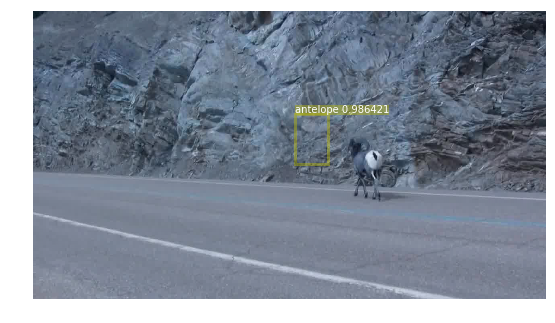

In [17]:
#while True:
f_iter_gap = 5
for _ in range(1):
    data_1, data_2 = next(data_iter)

im_data_1.data.resize_(data_1[0].size()).copy_(data_1[0])
im_info_1.data.resize_(data_1[1].size()).copy_(data_1[1])
gt_boxes_1.data.resize_(data_1[2].size()).copy_(data_1[2])
num_boxes_1.data.resize_(data_1[3].size()).copy_(data_1[3])

im_data_2.data.resize_(data_2[0].size()).copy_(data_2[0])
im_info_2.data.resize_(data_2[1].size()).copy_(data_2[1])
gt_boxes_2.data.resize_(data_2[2].size()).copy_(data_2[2])
num_boxes_2.data.resize_(data_2[3].size()).copy_(data_2[3])

data, im_data, im_info = data_2, im_data_2, im_info_2
input = im_data, im_info, template_weights, rois_tracking
det_tic = time.time()
siam_rois, siam_bbox_pred, siam_cls_prob, rois, rois_label, cls_prob, bbox_pred = RCNN(input)
#print('rois_tracking:',rois_tracking)
print('siam_rois:',siam_rois)
###########################################
# Get detection boxes.
###########################################
if cfg.TEST.BBOX_REG:
    scores = cls_prob.data
    boxes = rois.data[:, :, 1:5]
    pred_boxes = bbox_delta_to_pred_boxes(im_info, boxes, bbox_pred)
    pred_boxes /= data[1][0][2].item()
    scores = scores.squeeze()
    pred_boxes = pred_boxes.squeeze()
    if siam_bbox_pred is not None:
        siam_scores = siam_cls_prob.data
        siam_boxes = siam_rois.data[:, 1:5]
        pred_siam_bbox = bbox_delta_to_pred_boxes(im_info, siam_boxes.unsqueeze(0), siam_bbox_pred.unsqueeze(0))
        pred_siam_bbox /= data[1][0][2].item()
        pred_siam_bbox = pred_siam_bbox.squeeze(0)
        # concatenate siambox and detbox.
        # TODO
        #pred_boxes = torch.cat((pred_boxes, pred_siam_bbox), 0)
        #scores = torch.cat((scores, siam_scores), 0)
        pred_boxes = siam_boxes.repeat((siam_boxes.size(0),siam_boxes.size(1)*31))
        #pred_boxes = pred_siam_bbox
        scores = siam_scores
else:
    raise ValueError('Error. Should set cfg.TEST.BBOX_REG to True.')

det_toc = time.time()
detect_time = det_toc - det_tic
misc_tic = time.time()
###########################################
# NMS for detection and save to all boxes.
###########################################
for j in xrange(1, imdb.num_classes):
    inds = torch.nonzero(scores[:,j]>thresh).view(-1)
    # if there is det
    if inds.numel() > 0:
        cls_scores = scores[:,j][inds]
        all_scores = scores[inds]
        _, order = torch.sort(cls_scores, 0, True)
        if args.class_agnostic:
            cls_boxes = pred_boxes[inds, :]
        else:
            cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

        cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
        # cls_dets = torch.cat((cls_boxes, cls_scores), 1)
        cls_dets = cls_dets[order]
        all_scores = all_scores[order]
        ######### nms for each cls here ########
        keep = nms(cls_dets, cfg.TEST.NMS)
        cls_dets = cls_dets[keep.view(-1).long()]
        all_cls_scores = all_scores[keep.view(-1).long()]
        all_boxes[j][i] = cls_dets.cpu().numpy()
        all_boxes_scores[j][i] = all_cls_scores.cpu().numpy()
    else:
        all_boxes[j][i] = empty_array
        all_boxes_scores[j][i] = empty_array

# Limit to max_per_image detections *over all classes*
if max_per_image > 0:
    image_scores = np.hstack([all_boxes[j][i][:, -1]
                                for j in xrange(1, imdb.num_classes)])
    if len(image_scores) > max_per_image:
        image_thresh = np.sort(image_scores)[-max_per_image]
        for j in xrange(1, imdb.num_classes):
            keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0]
            all_boxes[j][i] = all_boxes[j][i][keep, :]
            all_boxes_scores[j][i] = all_boxes_scores[j][i][keep, :]
            
if img is not None:
    last_img = img
img = ((im_data_2.squeeze().cpu().numpy()).transpose(1,2,0)+np.array([[[102.9801, 115.9465, 122.7717]]])).astype(np.uint8)
show_det(im_info, img, all_boxes,i,0.01)

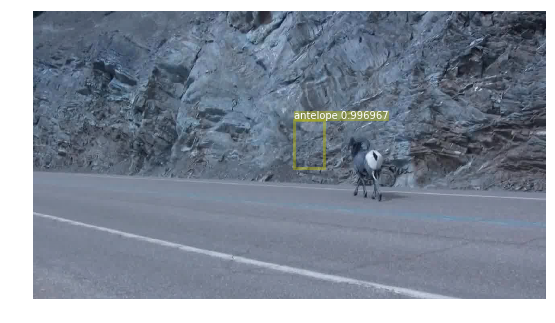

In [18]:
show_det(im_info, last_img, all_boxes,i-1,0.01)

In [16]:
########
# Get weights for the next iteration.
########
# First, convert all_boxes to rois_tracking.#
rois_tracking = prepare_rois_tracking(all_boxes, all_boxes_scores, frame_id=i, class_num=imdb.num_classes, thresh=cfg.SIAMESE.THRESH_FOR_TRACKING)
print(rois_tracking)
base_feat = RCNN.RCNN.Conv4_feat
template_weights, rois_tracking = siam_weights_preparation(rois_tracking, base_feat)

misc_toc = time.time()
nms_time = misc_toc - misc_tic

sys.stdout.write('im_detect: {:d}/{:d} {:.3f}s {:.3f}s   \r' \
  .format(i + 1, num_images, detect_time, nms_time))
sys.stdout.flush()
i+=1

scored_boxes[:, 4]: [1.6892493e-05]
thresh: 0.8
scored_boxes[:, 4]: [9.9696749e-01 2.4993911e-03 1.5073156e-03 1.4625420e-03 1.3848783e-03
 8.1934378e-04 5.9850892e-04 4.8719629e-04 3.9665718e-04 3.9155965e-04
 3.7314623e-04 3.1431281e-04 3.1429171e-04 2.2811527e-04 1.9662533e-04
 1.9606185e-04 1.8852593e-04 1.7196302e-04 1.6062206e-04 1.0830579e-04
 9.6044700e-05 7.9404061e-05 6.4958753e-05 6.3770371e-05 5.6884473e-05
 5.1944338e-05 5.1688079e-05 4.5000801e-05 4.1280684e-05 3.3732944e-05
 3.2814922e-05 2.8867524e-05 2.5371766e-05 2.4806013e-05 2.1159969e-05
 1.9936871e-05 1.9267420e-05 1.8811910e-05 1.4827660e-05 1.1529937e-05
 1.0113282e-05 9.9541458e-06 9.5283476e-06 6.9623093e-06 6.6348857e-06
 6.2637796e-06 5.7236066e-06 5.5549331e-06 4.9027799e-06 4.6984810e-06
 4.2559286e-06 4.1717817e-06 3.1633356e-06 2.5844790e-06 2.2679289e-06
 2.2275615e-06]
thresh: 0.8
scored_boxes[:, 4]: [1.7712013e-05 1.7516794e-06]
thresh: 0.8
scored_boxes[:, 4]: [2.1188316e-05 2.4900728e-06]
thresh: 0.8

In [16]:
print(all_boxes[2][:2])

[array([[6.0389508e+02, 1.1486813e+02, 1.0443707e+03, 5.8206641e+02,
        9.8718423e-01],
       [6.2459863e+02, 5.9899976e+02, 1.0660000e+03, 5.9900000e+02,
        2.1167624e-01],
       [7.2025311e+02, 5.9128125e+02, 1.0649167e+03, 5.9900000e+02,
        2.1110937e-01],
       [1.0139948e+03, 9.7524574e+01, 1.0650399e+03, 5.9900000e+02,
        2.0403931e-01],
       [1.0660000e+03, 1.9211336e+02, 1.0660000e+03, 5.3932758e+02,
        1.8273182e-01],
       [6.6042865e+02, 5.7303259e+02, 1.0637793e+03, 5.9900000e+02,
        1.7728806e-01],
       [1.0592104e+03, 2.3928731e+02, 1.0660000e+03, 5.9900000e+02,
        1.5949771e-01],
       [5.8237256e+02, 4.6283615e+02, 1.0660000e+03, 5.9685760e+02,
        1.4761168e-01],
       [8.9152271e+02, 2.5715924e+02, 1.0660000e+03, 5.9900000e+02,
        1.2602936e-01],
       [4.8367340e+02, 5.9670966e+02, 1.0660000e+03, 5.9900000e+02,
        1.0330442e-01]], dtype=float32), []]


In [ ]:
siam_rois, siam_bbox_pred, siam_cls_prob, rois, rois_label, cls_prob, bbox_pred

In [74]:
print(all_boxes[2][i-1])

[[7.23569092e+02 1.94329620e+02 1.23382458e+03 7.18800049e+02
  9.97645080e-01]
 [8.41480896e+02 7.18674988e+02 1.24239734e+03 7.18800049e+02
  1.56280860e-01]
 [7.99260254e+02 5.43576904e+02 1.27046545e+03 7.18800049e+02
  1.25254214e-01]
 [7.96239136e+02 6.93382446e+02 1.24014221e+03 7.18800049e+02
  1.24822386e-01]]


In [58]:
print(scores)

tensor([[ 8.6891e-01,  4.7157e-08,  1.3109e-01,  ...,  3.8370e-08,
          4.1531e-08,  4.9721e-08],
        [ 9.1641e-03,  7.7717e-07,  9.9082e-01,  ...,  5.1915e-07,
          5.3553e-07,  6.9115e-07],
        [ 8.9530e-01,  2.2193e-08,  1.0470e-01,  ...,  1.1744e-08,
          1.1448e-08,  1.7644e-08],
        ...,
        [ 9.9999e-01,  9.1179e-11,  6.4245e-06,  ...,  6.9521e-11,
          6.4254e-11,  1.0584e-10],
        [ 9.9988e-01,  7.8241e-08,  1.1190e-04,  ...,  9.7899e-08,
          9.3538e-08,  1.0352e-07],
        [ 9.8353e-01,  3.4587e-06,  1.6374e-02,  ...,  3.8802e-06,
          3.2994e-06,  2.8343e-06]], device='cuda:0')


In [54]:
print(template_weights)
print(rois_tracking)

None


In [37]:
print(rois_tracking)
#while True:
for i in range(50):
    data_1, data_2 = next(data_iter)

im_data_1.data.resize_(data_1[0].size()).copy_(data_1[0])
im_info_1.data.resize_(data_1[1].size()).copy_(data_1[1])
gt_boxes_1.data.resize_(data_1[2].size()).copy_(data_1[2])
num_boxes_1.data.resize_(data_1[3].size()).copy_(data_1[3])

im_data_2.data.resize_(data_2[0].size()).copy_(data_2[0])
im_info_2.data.resize_(data_2[1].size()).copy_(data_2[1])
gt_boxes_2.data.resize_(data_2[2].size()).copy_(data_2[2])
num_boxes_2.data.resize_(data_2[3].size()).copy_(data_2[3])

#print(im_data.shape)
RCNN.zero_grad()
##################################
#        Detection part          #
##################################
# detection loss for image 1.
rois_1, cls_prob_1, bbox_pred_1, \
rpn_loss_cls_1, rpn_loss_box_1, \
RCNN_loss_cls_1, RCNN_loss_bbox_1, \
rois_label_1 = RCNN(im_data_1, im_info_1, gt_boxes_1, num_boxes_1)

#c3_1, c4_1, c5_1 = RCNN.c_3, RCNN.c_4, RCNN.c_5
conv4_feat_1 = RCNN.Conv4_feat
rpn_rois_1 = RCNN.rpn_rois

# detection loss for image 2.
rois_2, cls_prob_2, bbox_pred_2, \
rpn_loss_cls_2, rpn_loss_box_2, \
RCNN_loss_cls_2, RCNN_loss_bbox_2, \
rois_label_2 = RCNN(im_data_2, im_info_2, gt_boxes_2, num_boxes_2)

#c3_2, c4_2, c5_2 = RCNN.c_3, RCNN.c_4, RCNN.c_5
conv4_feat_2 = RCNN.Conv4_feat
rpn_rois_2 = RCNN.rpn_rois

##################################
#        Tracking part           #
##################################
# define tracking loss here.
tracking_losses_cls_ls = []
tracking_losses_box_ls = []

rtv_training_tuples = t_t_prop_layer(conv4_feat_1, conv4_feat_2, None, gt_boxes_1, gt_boxes_2)
assert len(rtv_training_tuples)==1
tpl_id = 0
target_feat, template_weights, target_gt_boxes = rtv_training_tuples[tpl_id]
input_v = (target_feat,
           im_info_2[tpl_id:tpl_id+1], 
           template_weights,
           target_gt_boxes, 
           1)
siam_rois, rpn_loss_cls_siam, rpn_loss_box_siam = siameseRPN_layer(input_v)
tracking_losses_cls_ls.append(rpn_loss_cls_siam)
tracking_losses_box_ls.append(rpn_loss_box_siam)
#Show
img = np.squeeze(im_data_2.cpu().numpy())
det_rpn = rpn_rois_2.cpu().numpy()
siam_rpn = siam_rois.cpu().numpy()
img = img.transpose(1,2,0)
temp_img = (img+cfg.PIXEL_MEANS).astype(np.uint8)
temp_img = np.ascontiguousarray(temp_img[:,:,(2,1,0)])

#box = det_rpn[0,0,1:5].astype(np.int32)
#t_ = temp_img.copy()
#cv2.rectangle(t_,(box[0],box[1]),(box[2],box[3]),(0,255,0),8)
for i in range(3):
    box = det_rpn[0,i,1:5].astype(np.int32)
    t = temp_img.copy()
    cv2.rectangle(t,(box[0],box[1]),(box[2],box[3]),(0,255,0),8)
    #t_ = np.concatenate((t_,t),axis=0)
    plt.imshow(t)
    plt.show()
torch.cuda.empty_cache()

StopIteration: 

In [14]:
print(target_gt_boxes.shape)
print(gt_boxes_1.size())
print(gt_boxes_2.size())
print(template_weights.shape)
print(target_feat.shape)

torch.Size([1, 1, 6])
torch.Size([1, 30, 6])
torch.Size([1, 30, 6])
torch.Size([1, 1024, 5, 5])
torch.Size([1, 1024, 38, 67])


In [16]:
torch.cuda.empty_cache()

#### Examine the training tuple.

In [14]:
# remember to change the kernel size in cfg.SIAMESE.TEMPLATE_SZ
rtv_training_tuples = t_t_prop_layer(im_data_1, im_data_2, rpn_rois_1, gt_boxes_1, gt_boxes_2)

In [15]:
print(len(rtv_training_tuples))
target_feat, template_weights, target_gt_boxes = rtv_training_tuples[0]
print(target_feat.shape)
print(template_weights.shape)
print(target_gt_boxes.shape)

1
torch.Size([1, 3, 600, 1067])
torch.Size([4, 3, 5, 5])
torch.Size([4, 1, 6])


In [16]:
from matplotlib import pyplot as plt
import cv2

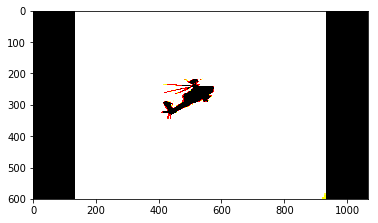

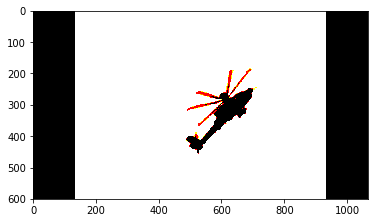

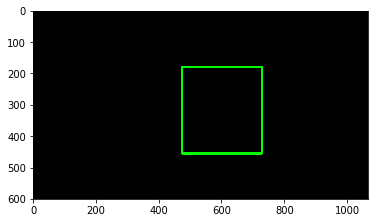

In [17]:
img = im_data_1[0].cpu().numpy()
plt.imshow(img.transpose(1,2,0))
plt.show()

img = im_data_2[0].cpu().numpy()
plt.imshow(img.transpose(1,2,0))
plt.show()

img = np.zeros(im_data_2[0].cpu().numpy().transpose(1,2,0).shape,dtype = np.uint8)
for it in range(target_gt_boxes.size(0)):
    tgt = target_gt_boxes[it,0,:]#.int()
    img = cv2.rectangle(img,(tgt[0],tgt[1]),(tgt[2],tgt[3]),(0,255,0),5)
plt.imshow(img)
plt.show()

tensor([[ 473.3333,  180.8333,  728.3333,  455.8333,    1.0000,    2.0000]], device='cuda:0')


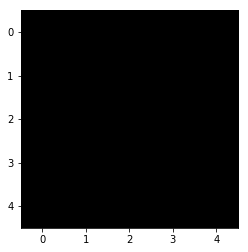

tensor([[ 473.3333,  180.8333,  728.3333,  455.8333,    1.0000,    2.0000]], device='cuda:0')


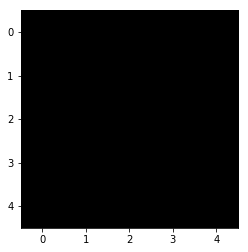

tensor([[ 473.3333,  180.8333,  728.3333,  455.8333,    1.0000,    2.0000]], device='cuda:0')


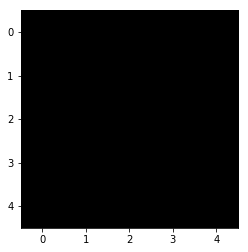

tensor([[ 473.3333,  180.8333,  728.3333,  455.8333,    1.0000,    2.0000]], device='cuda:0')


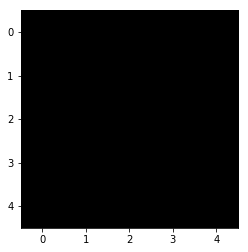

In [18]:
for idx in range(template_weights.size(0)):
    print(target_gt_boxes[idx,:,:])
    img = template_weights[idx,:,:,:].cpu().numpy()
    plt.imshow(img.transpose(1,2,0))
    plt.show()